# Traveling Salesman Problem
## Juan Marquina Cancino
## Ricardo Antonio Gutiérrez Esparza

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import math
import matplotlib.pyplot as plt

## 1) Read from file

In [2]:
def readSourceFile(filePath):
    r"""Recieves file path to a .csv table, representing ther distances matrix of a graph. First column and first row
    must be the nodes names, values should be separated by commas"""
    df = pd.read_csv(filePath)
    nodesNames = np.array(np.array(df.columns[1:]))
    distanceMatrix = np.array(df.values[:,1:])
    nodesDictionary = dict(zip(nodesNames, np.arange(len(nodesNames))))
    return nodesNames, nodesDictionary, distanceMatrix

In [3]:
path = '../dataset/'
fileName = 'adjacency_matrix.csv'
nodesNames, nodesDictionary, distanceMatrix = readSourceFile(path + fileName)
print("Nodes namnes:", nodesNames)
print("Nodes dictionary:", nodesDictionary)
print("Distance matrix:", distanceMatrix, sep='\n')


Nodes namnes: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
Nodes dictionary: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
Distance matrix:
[[0 59 48 69 54 91 55 34 81 72]
 [59 0 45 19 45 73 48 13 13 42]
 [48 45 0 97 11 65 12 58 70 45]
 [69 19 97 0 31 94 23 66 71 13]
 [54 45 11 31 0 95 37 47 24 49]
 [91 73 65 94 95 0 62 35 38 61]
 [55 48 12 23 37 62 0 82 96 47]
 [34 13 58 66 47 35 82 0 10 47]
 [81 13 70 71 24 38 96 10 0 63]
 [72 42 45 13 49 61 47 47 63 0]]


## 2) Generate N Nodes

In [4]:
def NumberToLetter(N):
    numberOfLetters = ord('Z') - ord('A') + 1
    asciiA = ord('A')
    result = ''
    while(N >= 0):
        result = chr(asciiA + N%26) + result
        N = int(N/26)
        if(N == 0):
            break
    return result


In [5]:
def CalculateDistance(A, B):
    return math.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2)

In [6]:
def GenerateNodes(numberOfNodes, limitLow, limitHigh):
    nodesNames = np.array([NumberToLetter(x) for x in np.arange(numberOfNodes)])
    nodesDictionary = dict(zip(nodesNames, np.arange(numberOfNodes)))
    rng = default_rng(16072001)
    nodesPosition = [ (rng.random()*(limitHigh-limitLow) + limitLow, rng.random()*(limitHigh-limitLow) + limitLow) for x in range(numberOfNodes)]
    distanceMatrix = np.array(list([CalculateDistance(nodesPosition[i], nodesPosition[j]) for j in range(numberOfNodes)] for i in range(numberOfNodes)))
    return nodesNames, nodesPosition, nodesDictionary, distanceMatrix

In [7]:
numberOfNodes = 4
limitLow = -100
limitHigh = 100
nodesNames, nodesPosition, nodesDictionary, distanceMatrix = GenerateNodes(numberOfNodes, limitLow, limitHigh)
print('Nodes Names:', nodesNames)
print('Nodes Position:', nodesPosition)
print('Nodes Dictionary: ', nodesDictionary)
print('Distance Matrix', distanceMatrix, sep='\n')

Nodes Names: ['A' 'B' 'C' 'D']
Nodes Position: [(86.74836895157574, 96.4943965054594), (-86.63483376855473, 84.04208524778474), (-95.87684156945602, 25.91066175533649), (50.77233455321419, 38.813054548947036)]
Nodes Dictionary:  {'A': 0, 'B': 1, 'C': 2, 'D': 3}
Distance Matrix
[[  0.         173.82978755 195.79078408  67.98096984]
 [173.82978755   0.          58.86150784 144.65958359]
 [195.79078408  58.86150784   0.         147.21566696]
 [ 67.98096984 144.65958359 147.21566696   0.        ]]


## 3) Objective Function 

In [8]:
def ObjectiveFunction(nodesNames, nodesDictionary, distanceMatrix, sol):
    r"""Solution is given in index form"""
    solution = list(sol)
    solution.append(solution[0])
    f = 0
    for i in range(1, len(solution)):
        f += distanceMatrix[solution[i-1]][solution[i]]
    return f


In [9]:
rng = default_rng(16072001)
solution = rng.permutation(numberOfNodes)
f = ObjectiveFunction(nodesNames, nodesDictionary, distanceMatrix, solution)
print(f)

447.8879321962664


## 4) Nodes positions randomly

In [10]:
def SolutionPermutation(nodesNames):
    numberOfNodes = len(nodesNames)
    rng = default_rng()
    return rng.permutation(numberOfNodes)

In [11]:
SolutionPermutation(nodesNames)

array([2, 3, 0, 1])

## 5) Genetic algorithm

In [12]:
def ParentSelectionRoulette(fitness):
    '''
        Input:  fitness -> Array of pop_size elements
        Output: Index of selected parent
    '''
    total = np.sum(fitness)
    roulette = np.cumsum(fitness / total)
    
    i = 0
    dart = np.random.uniform()
    while roulette[i] < dart:
        i += 1
    return i

In [13]:
def ParentSelectionTournament(fitness, k=2):
    '''
        Input:  fitness -> Array of pop_size elements
                k -> size of tournament
        Output: Index of selected parent
    '''
    rng = default_rng()
    selection = rng.permutation(len(fitness))
    not_selection = selection[k:]
    raffle = fitness.copy()
    raffle[not_selection] = np.max(raffle) + 1
    return np.argmin(raffle)
    

In [14]:
def CrossoverSimplePermutation(parent1, parent2):
    rng = default_rng()
    cut = rng.integers(low=0, high=len(parent1))
    offspring = np.append(parent1[:cut], parent2[cut:])
    
    used = np.zeros(len(parent1), dtype=int)
    for x in offspring:
        used[x] += 1
    unused = []
    for i,x in enumerate(used):
        if x == 0:
            unused.append(i)
    rng = default_rng()
    unused = rng.permutation(unused)
    
    for i,x in enumerate(offspring):
        if used[x] > 1:
            used[x] -= 1
            offspring[i] = unused[-1]
            unused = unused[:-1]
            
    return offspring

In [15]:
def CrossoverPartiallyMapped(parent1, parent2):
    rng = default_rng()
    cut1 = rng.integers(low=0, high=len(parent1))
    cut2 = rng.integers(low=cut1, high=len(parent1))
    offspring = np.append(parent2[:cut1], parent1[cut1:cut2])
    offspring = np.append(offspring, parent2[cut2:])
    
    used = np.zeros(len(parent1), dtype=int)
    for x in offspring:
        used[x] += 1
    unused = []
    for x in parent2[cut1:cut2]:
        if used[x] == 0:
            unused.append(x)
    unused = unused[::-1]
    
    for i,x in enumerate(offspring[:cut1]):
        if used[x] > 1:
            used[x] -= 1
            offspring[i] = unused[-1]
            unused = unused[:-1]
            
    for i,x in enumerate(offspring[cut2:]):
        if used[x] > 1:
            used[x] -= 1
            offspring[i + cut2] = unused[-1]
            unused = unused[:-1]
    
    return offspring
    

In [16]:
def MutationSwap(genotype):
    rng = default_rng()
    g = rng.integers(low=0, high=len(genotype), size=2)
    
    genotype[g[0]], genotype[g[1]] = genotype[g[1]], genotype[g[0]]
    
    return genotype

In [17]:
def TSPCrossover(population, fitness, Pr):
    rng = default_rng()
    new_population = []
    for i in range(len(population)): 
        if(rng.random() < Pr):
            parent1 = population[ParentSelectionTournament(fitness)]
            parent2 = population[ParentSelectionTournament(fitness)]
            new_population.append(CrossoverPartiallyMapped(parent1, parent2))
        else:
            new_population.append(population[ParentSelectionTournament(fitness)])
    
    return new_population
        

In [18]:
def TSPMutation(population, Pm):
    rng = default_rng()
    new_population = []
    for genotype in population:
        new_population.append(MutationSwap(genotype) if rng.random() < Pm else genotype)
    return new_population

In [19]:
def TSPGeneticAlgorithm(nodesNames, nodesDictionary, distanceMatrix, N=30, G=100, Pr=0.8, Pm=0.3):
    population = [SolutionPermutation(nodesNames) for i in range(N)]
    fitness = np.array([ObjectiveFunction(nodesNames, nodesDictionary, distanceMatrix, genotype) for genotype in population])
    elite = population[np.argmin(fitness)].copy()
    elite_fx = np.min(fitness)
    
    current_g = 0
    while current_g < G:
        print(f'Generation #{current_g}: elite = {elite}, fitness = {elite_fx}')
        population = TSPCrossover(population, fitness, Pr)
        population = TSPMutation(population, Pm)
        fitness = np.array([ObjectiveFunction(nodesNames, nodesDictionary, distanceMatrix, genotype) for genotype in population])
        if(np.min(fitness) > elite_fx):
            max_idx = np.argmax(fitness)
            population[max_idx] = elite
            fitness[max_idx] = elite_fx
        else:
            elite = population[np.argmin(fitness)].copy()
            elite_fx = np.min(fitness)
            
        current_g +=1
    
    return elite, elite_fx
    

In [20]:
numberOfNodes = 10
limitLow = -100
limitHigh = 100
nodesNames, nodesPosition, nodesDictionary, distanceMatrix = GenerateNodes(numberOfNodes, limitLow, limitHigh)
print('Nodes Names:', nodesNames)
print('Nodes Position:', nodesPosition)
print('Nodes Dictionary: ', nodesDictionary)
print('Distance Matrix', distanceMatrix, sep='\n')

Nodes Names: ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
Nodes Position: [(86.74836895157574, 96.4943965054594), (-86.63483376855473, 84.04208524778474), (-95.87684156945602, 25.91066175533649), (50.77233455321419, 38.813054548947036), (30.42912360152482, -7.335740728161497), (-95.06187977261678, -31.61216348632348), (59.62333011223711, 95.65384283789243), (-96.02336150837785, -76.76974632941634), (-97.90440933132115, 36.02573039751286), (40.520466820864215, 23.909231048874503)]
Nodes Dictionary:  {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9}
Distance Matrix
[[  0.         173.82978755 195.79078408  67.98096984 118.12093292
  222.4101105   27.1380593  251.8451283  194.3015906   86.05594215]
 [173.82978755   0.          58.86150784 144.65958359 148.50547867
  115.96085699 146.71838132 161.08565929  49.32112799 140.65713854]
 [195.79078408  58.86150784   0.         147.21566696 130.60826971
   57.52859799 170.42421982 102.68051262  10.31628056 136.4119916

After experimenting, we found that Tournament Parent Selection works best for TSP. Crossover method doesn't seem to matter that much, so we used Partially Mapped Crossover. 

In [21]:
elite, elite_fx = TSPGeneticAlgorithm(nodesNames, nodesDictionary, distanceMatrix)
print(elite, elite_fx)

Generation #0: elite = [8 5 7 3 4 0 6 9 2 1], fitness = 814.2347703858554
Generation #1: elite = [8 5 7 3 4 0 6 9 2 1], fitness = 814.2347703858554
Generation #2: elite = [8 5 7 3 4 0 6 9 2 1], fitness = 814.2347703858554
Generation #3: elite = [9 4 3 7 5 2 1 8 0 6], fitness = 776.6686186569541
Generation #4: elite = [9 4 3 7 5 2 1 8 0 6], fitness = 776.6686186569541
Generation #5: elite = [9 4 3 7 5 2 1 8 0 6], fitness = 776.6686186569541
Generation #6: elite = [9 4 3 7 5 2 1 8 0 6], fitness = 776.6686186569541
Generation #7: elite = [9 4 3 7 5 2 1 8 0 6], fitness = 776.6686186569541
Generation #8: elite = [9 3 0 6 1 5 7 8 2 4], fitness = 707.625331533873
Generation #9: elite = [9 3 0 6 1 5 7 8 2 4], fitness = 707.625331533873
Generation #10: elite = [9 3 0 6 1 5 7 8 2 4], fitness = 707.625331533873
Generation #11: elite = [9 3 0 6 1 5 7 8 2 4], fitness = 707.625331533873
Generation #12: elite = [3 9 4 7 5 2 1 8 0 6], fitness = 685.0292803003275
Generation #13: elite = [3 9 4 7 5 2 1 

## 6) Plot the final solution

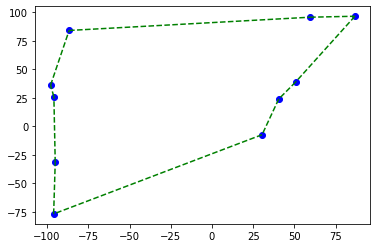

In [22]:
plt.figure()

for pos in nodesPosition:
    plt.scatter(pos[0], pos[1], color='b')

for i in range(len(elite)-1):
    plt.plot([nodesPosition[elite[i]][0], nodesPosition[elite[i+1]][0]], [nodesPosition[elite[i]][1], nodesPosition[elite[i+1]][1]], color='g', linestyle='--')
plt.plot([nodesPosition[elite[-1]][0], nodesPosition[elite[0]][0]], [nodesPosition[elite[-1]][1], nodesPosition[elite[0]][1]], color='g', linestyle='--')
    

plt.show()